![](img/571_banner.png)

# Lecture 5: More preprocessing, text features

UBC Master of Data Science program, 2022-23

Instructor: Varada Kolhatkar

## Imports, Announcements, and LO

### Imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append("code/.")
from plotting_functions import *
from utils import *

pd.set_option("display.max_colwidth", 200)

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### Learning outcomes 

From this lecture, you will be able to 

- spot problems with commonly used improper methodologies used in preprocessing; 
- explain the difference between ordinal encoding vs one-hot encoding;
- explain possible strategies to deal with categorical variables with too many categories; 
- explain why text data needs a different treatment than categorical variables;
- use `scikit-learn`'s `CountVectorizer` to encode text data;
- explain and use different hyperparameters of `CountVectorizer`.
- incorporate text features in a machine learning pipeline

<br><br><br><br>

## ❓❓ Questions for you

Let's create some synthetic data. 

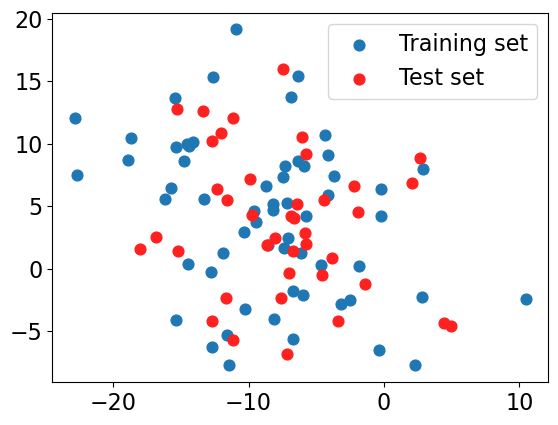

In [2]:
from sklearn.datasets import make_blobs, make_classification

# make synthetic data
X, y = make_blobs(n_samples=100, centers=3, random_state=12, cluster_std=5)
# split it into training and test sets
X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(
    X, y, random_state=5, test_size=0.4)

plt.scatter(X_train_toy[:, 0], X_train_toy[:, 1], label="Training set", s=60)
plt.scatter(
    X_test_toy[:, 0], X_test_toy[:, 1], color=mglearn.cm2(1), label="Test set", s=60
)
plt.legend(loc="upper right");

Let's transform the data using `StandardScaler` and examine how the data looks like. 

In [3]:
scaler = StandardScaler()
train_transformed = scaler.fit_transform(X_train_toy)
test_transformed = scaler.transform(X_test_toy)

In [4]:
X_train_toy[:, 0].mean(), X_train_toy[:, 0].std()

(-8.600287211119548, 6.270246946519936)

In [5]:
X_train_toy[:, 1].mean(), X_train_toy[:, 1].std()

(4.124686209266641, 6.2749592279985595)

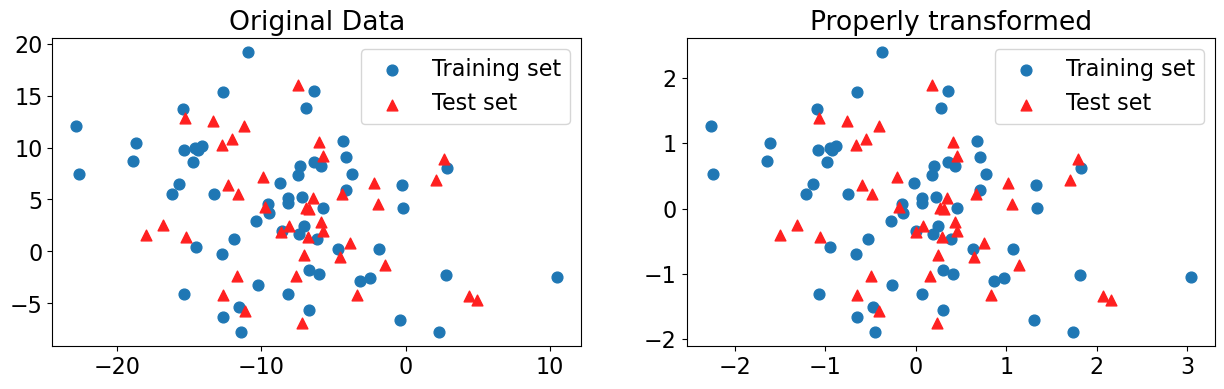

In [6]:
plot_original_scaled(X_train_toy, X_test_toy, train_transformed, test_transformed)

In [7]:
knn = KNeighborsClassifier()
knn.fit(train_transformed, y_train_toy)
print(f"Training score: {knn.score(train_transformed, y_train_toy):.2f}")
print(f"Test score: {knn.score(test_transformed, y_test_toy):.2f}")

Training score: 0.63
Test score: 0.55


<br><br>

#### Bad methodology 1: Scaling the data separately (for class discussion)

In [8]:
# DO NOT DO THIS! For illustration purposes only.
scaler = StandardScaler()
scaler.fit(X_train_toy)
train_scaled = scaler.transform(X_train_toy)

scaler = StandardScaler()  # Creating a separate object for scaling test data
scaler.fit(X_test_toy)  # Calling fit on the test data
test_scaled = scaler.transform(
    X_test_toy
)  # Transforming the test data using the scaler fit on test data

knn = KNeighborsClassifier()
knn.fit(train_scaled, y_train_toy)
print(f"Training score: {knn.score(train_scaled, y_train_toy):.2f}")
print(f"Test score: {knn.score(test_scaled, y_test_toy):.2f}")

Training score: 0.63
Test score: 0.60


- Is anything wrong in methodology 1? If yes, what is it?  

<br><br><br><br>

- What are the mean and standard deviation of columns in `X_train_toy` and `X_test_toy`? 

In [9]:
X_train_toy[:, 0].mean(), X_train_toy[:, 0].std() # mean and std of column 1 in X_train_toy

(-8.600287211119548, 6.270246946519936)

In [10]:
X_train_toy[:, 1].mean(), X_train_toy[:, 1].std() # mean and std of column 2 in X_train_toy

(4.124686209266641, 6.2749592279985595)

What are the mean and standard deviation of columns in `X_test_toy`?  

In [11]:
X_test_toy[:, 0].mean(), X_test_toy[:, 0].std() # mean and std of column 1 in X_test_toy

(-7.4360796317881865, 5.415791218175097)

In [12]:
X_test_toy[:, 1].mean(), X_test_toy[:, 1].std() # mean and std of column 2 in X_train_toy

(3.584450392629585, 5.5947435906433025)

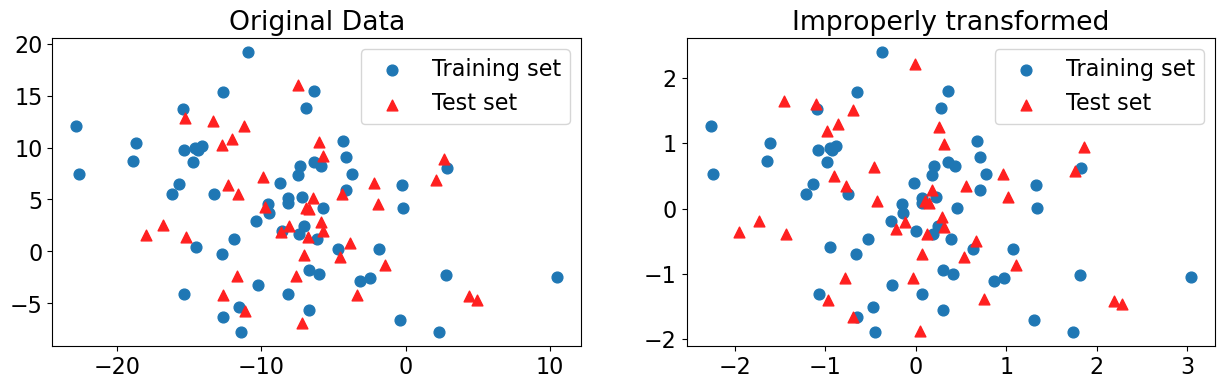

In [13]:
plot_original_scaled(
    X_train_toy,
    X_test_toy,
    train_scaled,
    test_scaled,
    title_transformed="Improperly transformed",
)

<br><br>

#### Bad methodology 2: Scaling the data together (for class discussion)

In [14]:
X_train_toy.shape, X_test_toy.shape

((60, 2), (40, 2))

In [15]:
# join the train and test sets back together
XX = np.vstack((X_train_toy, X_test_toy))
XX.shape

(100, 2)

In [16]:
scaler = StandardScaler()
scaler.fit(XX)
XX_scaled = scaler.transform(XX)
XX_train = XX_scaled[:X_train_toy.shape[0]]
XX_test = XX_scaled[X_train_toy.shape[0]:]

In [17]:
knn = KNeighborsClassifier()
knn.fit(XX_train, y_train_toy)
print(f"Training score: {knn.score(XX_train, y_train_toy):.2f}")  # Misleading score
print(f"Test score: {knn.score(XX_test, y_test_toy):.2f}")  # Misleading score

Training score: 0.63
Test score: 0.55


- Is anything wrong in methodology 2? If yes, what is it? 
- What's are the mean and std of `X_train_toy` vs. `XX`?

In [18]:
X_train_toy[:, 0].mean(), X_train_toy[:, 0].std() # mean and std of column 1 in X_train_toy

(-8.600287211119548, 6.270246946519936)

In [19]:
X_train_toy[:, 1].mean(), X_train_toy[:, 1].std() # mean and std of column 2 in X_train_toy

(4.124686209266641, 6.2749592279985595)

What are the mean and standard deviation of columns in `XX`?  

In [20]:
XX[:, 0].mean(), XX[:, 0].std() # mean and std of column 1 in XX

(-8.134604179387004, 5.970528192615454)

In [21]:
XX[:, 1].mean(), XX[:, 1].std() # mean and std of column 2 in XX

(3.9085918826118187, 6.017937808158447)

There is no big difference but they are not the same. 

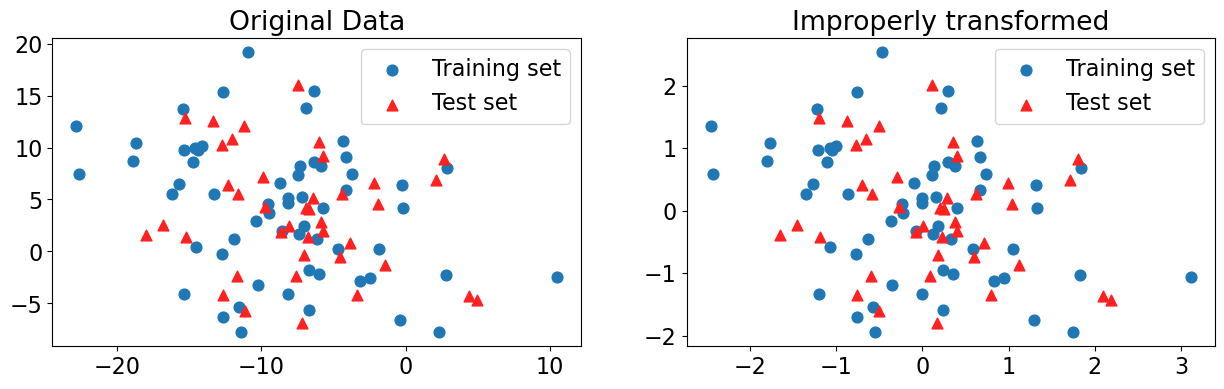

In [22]:
plot_original_scaled(
    X_train_toy,
    X_test_toy,
    XX_train,
    XX_test,
    title_transformed="Improperly transformed",
)

Not a noticeable difference in the transformed data and in scores in this case. But there is information leakage which is not good.   

<br><br><br><br>

## More discussion on preprocessing

Let's bring back our quiz2 grades toy dataset. 

In [23]:
grades_df = pd.read_csv('data/quiz2-grade-toy-col-transformer.csv')
grades_df.head()

,enjoy_course,ml_experience,major,class_attendance,university_years,lab1,lab2,lab3,lab4,quiz1,quiz2
0,yes,1,Computer Science,Excellent,3,92,93.0,84,91,92,A+
1,yes,1,Mechanical Engineering,Average,2,94,90.0,80,83,91,not A+
2,yes,0,Mathematics,Poor,3,78,85.0,83,80,80,not A+
3,no,0,Mathematics,Excellent,3,91,NaN,92,91,89,A+
4,yes,0,Psychology,Good,4,77,83.0,90,92,85,A+


In [24]:
X, y = grades_df.drop(columns=['quiz2']), grades_df['quiz2']

In [25]:
numeric_feats = ["university_years", "lab1", "lab3", "lab4", "quiz1"]  # apply scaling
categorical_feats = ["major"]  # apply one-hot encoding
passthrough_feats = ["ml_experience"]  # do not apply any transformation
drop_feats = [
    "lab2",
    "class_attendance",
    "enjoy_course",
]  # do not include these features in modeling

### One-hot encoding 
- What's the purpose of the following arguments of one-hot encoding?
    - handle_unknown="ignore"
    - sparse=False
    - drop="if_binary"    
- How do you deal with categorical features with only two possible categories? 

### Categorical features with only two possible categories

- Sometimes you have features with only two possible categories. 
- If we apply `OheHotEncoder` on such columns, it'll create two columns, which seems wasteful, as we could represent all information in the column in just one column with say 0's and 1's with presence of absence of one of the categories.
- You can pass `drop="if_binary"` argument to `OneHotEncoder` in order to create only one column in such scenario. 

In [26]:
X["enjoy_course"].head()

0    yes
1    yes
2    yes
3     no
4    yes
Name: enjoy_course, dtype: object

In [27]:
ohe_enc = OneHotEncoder(drop="if_binary", dtype=int, sparse=False)
ohe_enc.fit(X[["enjoy_course"]])
transformed = ohe_enc.transform(X[["enjoy_course"]])
df = pd.DataFrame(data=transformed, columns=["enjoy_course_enc"], index=X.index)
pd.concat([X[["enjoy_course"]], df], axis=1).head(10)

,enjoy_course,enjoy_course_enc
0,yes,1
1,yes,1
2,yes,1
3,no,0
4,yes,1
5,no,0
6,yes,1
7,no,0
8,no,0
9,yes,1


### Ordinal encoding (class discussion)

- What's the difference between ordinal encoding and one-hot encoding? 
- What happens if we do not order the categories when we apply ordinal encoding?  Does it matter if we order the categories in ascending or descending order? 
- What would happen if an unknown category shows up during validation or test time during ordinal encoding? For example, for `class_attendance` feature what if a category called "super poor" shows up? 

<br><br><br><br>

### More than one ordinal columns?

- We can pass the manually ordered categories when we create an `OrdinalEncoder` object as a list of lists. 
- If you have more than one ordinal columns
    - manually create a list of ordered categories for each column
    - pass a list of lists to `OrdinalEncoder`, where each inner list corresponds to manually created list of ordered categories for a corresponding ordinal column. 
    

#### Discussion question

Since `enjoy_course` feature is binary you decide to apply one-hot encoding with `drop="if_binary"`. Your friend decide to apply ordinal encoding on it. Will it make any difference in the transformed data? 

In [28]:
ohe = OneHotEncoder(drop="if_binary", sparse=False)
ohe_encoded = ohe.fit_transform(grades_df[['enjoy_course']]).ravel()

In [29]:
oe = OrdinalEncoder()
oe_encoded = oe.fit_transform(grades_df[['enjoy_course']]).ravel()

In [30]:
data = { "oe_encoded": oe_encoded, 
         "ohe_encoded": ohe_encoded}
pd.DataFrame(data)

,oe_encoded,ohe_encoded
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,0.0,0.0
4,1.0,1.0
5,0.0,0.0
6,1.0,1.0
7,0.0,0.0
8,0.0,0.0
9,1.0,1.0


### Cases where it's OK to break the golden rule 

- If it's some fix number of categories. For example, if it's something like provinces in Canada or majors taught at UBC. We know the categories in advance and this is one of the cases where it might be OK to violate the golden rule and pass the list of known/possible categories. It's OK to incorporate human knowledge in the model. 

### OHE with many categories

- Do we have enough data for rare categories to learn anything meaningful? 
- How about grouping them into bigger categories?
    - Example: country names into continents such as "South America" or "Asia"
- How about considering the most frequent categories and having "other" category for rare cases? 

### Do we actually want to use certain features for prediction?

- Do you want to use certain features such as **gender** or **race** in prediction?
- Remember that the systems you build are going to be used in some applications. 
- It's extremely important to be mindful of the consequences of including certain features in your predictive model. 

### Preprocessing the targets?

- Generally no need for this when doing classification. 
- `sklearn` is fine with categorical labels ($y$-values) for classification problems. 
- But if you are using something outside `sklearn`, you might want to apply [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) on the target. 
- In regression it makes sense in some cases. More on this in DSCI 573. 

### Interim summary 

- We have only scratched the surface of preprocessing to get us going. 
- In general, there is no one perfect solution to preprocessing. 
- You as a machine learning practitioner need to carefully look at the data, make appropriate decisions, and justify your decisions in the given situation. -- You are likely to follow the steps below in the process.  
    - Have a long conversation with the stakeholder(s) who will be using your pipeline.
    - Have a long conversation with the person(s) who collected the data.
    - Think about the ethical implications - are you sure you want to do this project? If so, should ethics guide your approach?

<br><br>

## Break (5 min)

![](img/eva-coffee.png)


So far we talked about data where
- we have a fixed number of features
- features are either continuous or categorical

There are many types of data where there are no predefined features or fixed length descriptions.  
- free text data
- image data 
- audio data
- video data 

In such cases, we need to come up with some representation or fixed length description which is useful for our task.  

Let's focus on text data. Let's look at some example reviews from IMDB. 

In [31]:
imdb_df = pd.read_csv("data/imdb_master.csv", encoding="ISO-8859-1")
imdb_df['review'].loc[10302]

'Three young college women, Simona (Iva Krajnc), Alja (Tanja Potocnik), and Zana (Pia Zemljic), go on an adventure canoing down the River Kolpa, dividing their Slovenia from neighboring Croatia, in this 2002 Slovenian film by Maya Weiss. What could have been an Eastern European version of the well-known and exciting 1972 "Deliverance" turned out, for me, to be utterly uninspiring with flat character portrayals that denied sympathetic identification with the characters.<br /><br />Alja and Zana are not convincing as students at all, though Alja expresses a desire to be a writer, and both use what seemed to me to be excessive bad language. Alja is bored with her boyfriend and seems to just be drifting along in life. Zana, even less scholarly, is a self-absorbed adventure seeker with an attraction to other women. I had some sympathy with relatively innocent Simona, conservative and starry eyed. The very idea of these three traveling together just doesn\'t work for me. The disdain that Zan

In [32]:
imdb_df['review'].loc[10]

'Cage plays a drunk and gets high critically praise. Elizabeth Shue Actually has to do a love seen with the most unattractive and overrated piece of dung flesh in Hollywood. I literally vomited while watching this film. Of course I had the flu, but that does not mean this film did not contribute to the vomit in the kamode. <br /><br />Why can\'t Nick Cage play something he can really pull off like a bad actor. Nick Cage who be brilliant in a role as a bad actor. Heck nobody could do it better.<br /><br />The search begins for Nick\'s contract with Lucifer or was it Lou Cipher from "Night Train To Terror".'

- This is how the text looks like in the wild. 
- Clearly they do not have the same length.
- There is no obvious way to represent these strings as floating point numbers which is required by standard machine learning approaches. 
- There are some weird things going on in these texts
    - HTML markup
    - Capitalization 
    - Punctuation marks
    - Misspellings
    - Proper names

- How to tokenize? 
- How to normalize words?
- What to include in the vocabulary? 
    - exclude stopwords (most common words)
    - exclude rarely occurring words

<br><br><br><br>

## Encoding text data  

In [33]:
toy_spam = [
    [
        "URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",
        "spam",
    ],
    ["Lol you are always so convincing.", "non spam"],
    ["Nah I don't think he goes to usf, he lives around here though", "non spam"],
    [
        "URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!",
        "spam",
    ],
    [
        "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030",
        "spam",
    ],
    ["Congrats! I can't wait to see you!!", "non spam"],
]
toy_df = pd.DataFrame(toy_spam, columns=["sms", "target"])

### Spam/non spam toy example 

- What if the feature is in the form of raw text?
- The feature `sms` below is neither categorical nor ordinal. 
- How can we encode it so that we can pass it to the machine learning algorithms we have seen so far? 

In [34]:
toy_df

,sms,target
0,URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,spam
1,Lol you are always so convincing.,non spam
2,"Nah I don't think he goes to usf, he lives around here though",non spam
3,URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,spam
4,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,spam
5,Congrats! I can't wait to see you!!,non spam


### What if we apply OHE? 

In [35]:
### DO NOT DO THIS.
enc = OneHotEncoder(sparse=False)
transformed = enc.fit_transform(toy_df[["sms"]])
pd.DataFrame(transformed, columns=enc.categories_)

,Congrats! I can't wait to see you!!,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,Lol you are always so convincing.,"Nah I don't think he goes to usf, he lives around here though",URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0


- We do not have a fixed number of categories here. 
- Each "category" (feature value) is likely to occur only once in the training data and we won't learn anything meaningful if we apply one-hot encoding or ordinal encoding on this feature. 

- How can we encode or represent raw text data into fixed number of features so that we can learn some useful patterns from it?  
- This is a well studied problem in the field of Natural Language Processing (NLP), which is concerned with giving computers the ability to understand written and spoken language. 
- Some popular representations of raw text include: 
    - **Bag of words** 
    - TF-IDF
    - Embedding representations 

### Bag of words (BOW) representation

- One of the most popular representation of raw text 
- Ignores the syntax and word order
- It has two components: 
    - The vocabulary (all unique words in all documents) 
    - A value indicating either the presence or absence or the count of each word in the document. 
        
<center>
<img src='./img/bag-of-words.png' width="600">
</center>

[Source](https://web.stanford.edu/~jurafsky/slp3/4.pdf)       

### Extracting BOW features using `scikit-learn`
- `CountVectorizer`
    - Converts a collection of text documents to a matrix of word counts.  
    - Each row represents a "document" (e.g., a text message in our example). 
    - Each column represents a word in the vocabulary (the set of unique words) in the training data. 
    - Each cell represents how often the word occurs in the document.       

```{note}
In the Natural Language Processing (NLP) community text data  is referred to as a **corpus** (plural: corpora). ```   

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X_counts = vec.fit_transform(toy_df["sms"])
bow_df = pd.DataFrame(
    X_counts.toarray(), columns=vec.get_feature_names_out(), index=toy_df["sms"]
)
bow_df

,08002986030,100000,11,900,always,are,around,as,been,call,...,update,urgent,usf,valued,wait,week,with,won,you,your
sms,,,,,,,,,,,,,,,,,,,,,
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,0,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
Lol you are always so convincing.,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
"Nah I don't think he goes to usf, he lives around here though",0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,1,0,1,0,0,0,0,0,0,1,...,2,0,0,0,0,0,1,0,0,1
Congrats! I can't wait to see you!!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [37]:
type(toy_df["sms"])

pandas.core.series.Series

```{important}
Note that unlike other transformers we are passing a `Series` object to `fit_transform`. For other transformers, you can define one transformer for more than one columns. But with `CountVectorizer` you need to define separate `CountVectorizer` transformers for each text column, if you have more than one text columns.    
```

In [38]:
X_counts

<6x61 sparse matrix of type '<class 'numpy.int64'>'
	with 71 stored elements in Compressed Sparse Row format>

### Why sparse matrices? 

- Most words do not appear in a given document.
- We get massive computational savings if we only store the nonzero elements.
- There is a bit of overhead, because we also need to store the locations:
    - e.g. "location (3,27): 1".
    
- However, if the fraction of nonzero is small, this is a huge win.

In [39]:
print("The total number of elements: ", np.prod(X_counts.shape))
print("The number of non-zero elements: ", X_counts.nnz)
print(
    "Proportion of non-zero elements: %0.4f" % (X_counts.nnz / np.prod(X_counts.shape))
)
print(
    "The value at cell 3,%d is: %d"
    % (vec.vocabulary_["jackpot"], X_counts[3, vec.vocabulary_["jackpot"]])
)

The total number of elements:  366
The number of non-zero elements:  71
Proportion of non-zero elements: 0.1940
The value at cell 3,27 is: 1



Question for you
- What would happen if you apply `StandardScaler` on sparse data? 

### `OneHotEncoder` and sparse features 
- By default, `OneHotEncoder` also creates sparse features. 
- You could set `sparse=False` to get a regular `numpy` array. 
- If there are a huge number of categories, it may be beneficial to keep them sparse.
- For smaller number of categories, it doesn't matter much.

### Important hyperparameters of `CountVectorizer` 

- `binary`
    - whether to use absence/presence feature values or counts
- `max_features`
    - only consider top `max_features` ordered by frequency in the corpus
- `max_df`
    - ignore features which occur in more than `max_df` documents 
- `min_df` 
    - ignore features which occur in less than `min_df` documents 
- `ngram_range`
    - consider word sequences in the given range 

Let's look at all features, i.e., words (along with their frequencies).

In [40]:
vec = CountVectorizer()
X_counts = vec.fit_transform(toy_df["sms"])
bow_df = pd.DataFrame(
    X_counts.toarray(), columns=vec.get_feature_names_out(), index=toy_df["sms"]
)
bow_df

,08002986030,100000,11,900,always,are,around,as,been,call,...,update,urgent,usf,valued,wait,week,with,won,you,your
sms,,,,,,,,,,,,,,,,,,,,,
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,0,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
Lol you are always so convincing.,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
"Nah I don't think he goes to usf, he lives around here though",0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,1,0,1,0,0,0,0,0,0,1,...,2,0,0,0,0,0,1,0,0,1
Congrats! I can't wait to see you!!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


When we use `binary=True`, the representation uses presence/absence of words instead of word counts.   

In [41]:
vec_binary = CountVectorizer(binary=True)
X_counts = vec_binary.fit_transform(toy_df["sms"])
bow_df = pd.DataFrame(
    X_counts.toarray(), columns=vec_binary.get_feature_names_out(), index=toy_df["sms"]
)
bow_df

,08002986030,100000,11,900,always,are,around,as,been,call,...,update,urgent,usf,valued,wait,week,with,won,you,your
sms,,,,,,,,,,,,,,,,,,,,,
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,0,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
Lol you are always so convincing.,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
"Nah I don't think he goes to usf, he lives around here though",0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,1,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,1
Congrats! I can't wait to see you!!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


We can control the size of X (the number of features) using `max_features`.

In [42]:
vec8 = CountVectorizer(max_features=8)
X_counts = vec8.fit_transform(toy_df["sms"])
bow_df = pd.DataFrame(
    X_counts.toarray(), columns=vec8.get_feature_names_out(), index=toy_df["sms"]
)
bow_df

,free,have,mobile,the,to,update,urgent,you
sms,,,,,,,,
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,1,0,0,1,0,1,1
Lol you are always so convincing.,0,0,0,0,0,0,0,1
"Nah I don't think he goes to usf, he lives around here though",0,0,0,0,1,0,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,1,1,0,0,0,0,1,1
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,2,0,2,2,2,2,0,0
Congrats! I can't wait to see you!!,0,0,0,0,1,0,0,1


```{note}
Notice that `vec8` and `vec8_binary` have different vocabularies, which is kind of unexpected behaviour and doesn't match the documentation of `scikit-learn`. 

[Here](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/text.py#L1206-L1225) is the code for `binary=True` condition in `scikit-learn`. As we can see, the binarization is done before limiting the features to `max_features`, and so now we are actually looking at the document counts (in how many documents it occurs) rather than term count. This is not explained anywhere in the documentation. 

The ties in counts between different words makes it even more confusing. I don't think it'll have a big impact on the results but this is good to know! Remember that `scikit-learn` developers are also humans who are prone to make mistakes. So it's always a good habit to question whatever tools we use every now and then. 
```

In [43]:
vec8 = CountVectorizer(max_features=8)
X_counts = vec8.fit_transform(toy_df["sms"])
pd.DataFrame(
    data=X_counts.sum(axis=0).tolist()[0],
    index=vec8.get_feature_names_out(),
    columns=["counts"],
).sort_values("counts", ascending=False)

,counts
to,5
you,4
free,3
have,2
mobile,2
the,2
update,2
urgent,2


In [44]:
vec8_binary = CountVectorizer(binary=True, max_features=8)
X_counts = vec8_binary.fit_transform(toy_df["sms"])
pd.DataFrame(
    data=X_counts.sum(axis=0).tolist()[0],
    index=vec8_binary.get_feature_names_out(),
    columns=["counts"],
).sort_values("counts", ascending=False)

,counts
to,4
you,4
free,2
have,2
prize,2
urgent,2
mobiles,1
months,1


### Preprocessing

- Note that `CountVectorizer` is carrying out some preprocessing such as because of the default argument values 
    - Converting words to lowercase (`lowercase=True`)
    - getting rid of punctuation and special characters (`token_pattern ='(?u)\\b\\w\\w+\\b'`)


In [45]:
pipe = make_pipeline(CountVectorizer(), SVC())

In [46]:
pipe.fit(toy_df["sms"], toy_df["target"])

Pipeline(steps=[('countvectorizer', CountVectorizer()), ('svc', SVC())])

In [47]:
pipe.predict(toy_df["sms"])

array(['spam', 'non spam', 'non spam', 'spam', 'spam', 'non spam'],
      dtype=object)

### Is this a realistic representation of text data? 

- Of course this is not a great representation of language
    - We are throwing out everything we know about language and losing a lot of information. 
    - It assumes that there is no syntax and compositional meaning in language.  
- But it works surprisingly well for many tasks. 
- We will learn more expressive representations in the coming weeks. 

<br><br>

## (Optional) tf-idf representation

- Another common way to represent text is using tf-idf representation, which stands for term frequency inverse document frequency.
- This is an alternative to using using stop words or putting more emphasis on rare or more specific words. 
- If something appears in most of the documents then the inverse document frequency gives it a lower weight. 
- This is commonly used in information retrieval, which is the field of finding relevant documents. But people also find it useful in machine learning. 

$$\text{tf-idf}(t, d) = tf(t, d) . \text{idf}(t,d)$$ 
$$\text{idf}(t,d) = log \frac{1 + n_d}{1 + df(d, t)} + 1$$

where
- $n_d \rightarrow $ total number of documents
- $df(d, t) \rightarrow $ number of documents containing the term $t$



- How to do this in `sklearn`? There are two ways: 
    - Using TfidfVectorizer directly 
    - Creating a pipeline with `CountVectorizer` and `TfidfTransformer`

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
tfidf1 = TfidfVectorizer()
X_tfidf1 = tfidf1.fit_transform(toy_df["sms"])
pd.DataFrame(X_tfidf1.toarray(), columns = tfidf1.get_feature_names_out().tolist())

,08002986030,100000,11,900,always,are,around,as,been,call,...,update,urgent,usf,valued,wait,week,with,won,you,your
0,0.000000,0.000000,0.000000,0.292088,0.000000,0.000000,0.00000,0.292088,0.292088,0.000000,...,0.000000,0.239517,0.00000,0.292088,0.000000,0.000000,0.000000,0.000000,0.173284,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.432259,0.432259,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256441,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.27367,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.27367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.315571,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.258773,0.00000,0.000000,0.000000,0.315571,0.000000,0.315571,0.187216,0.000000
4,0.173821,0.000000,0.173821,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.173821,...,0.347642,0.000000,0.00000,0.000000,0.000000,0.000000,0.173821,0.000000,0.000000,0.173821
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.461074,0.000000,0.000000,0.000000,0.273536,0.000000


In [49]:
tfidf2 = make_pipeline(CountVectorizer(), TfidfTransformer())
X_tfidf2 = tfidf2.fit_transform(toy_df["sms"])
pd.DataFrame(X_tfidf2.toarray(), columns = tfidf2.get_feature_names_out().tolist())

,08002986030,100000,11,900,always,are,around,as,been,call,...,update,urgent,usf,valued,wait,week,with,won,you,your
0,0.000000,0.000000,0.000000,0.292088,0.000000,0.000000,0.00000,0.292088,0.292088,0.000000,...,0.000000,0.239517,0.00000,0.292088,0.000000,0.000000,0.000000,0.000000,0.173284,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.432259,0.432259,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256441,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.27367,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.27367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.315571,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.258773,0.00000,0.000000,0.000000,0.315571,0.000000,0.315571,0.187216,0.000000
4,0.173821,0.000000,0.173821,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.173821,...,0.347642,0.000000,0.00000,0.000000,0.000000,0.000000,0.173821,0.000000,0.000000,0.173821
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.461074,0.000000,0.000000,0.000000,0.273536,0.000000


By default, `sklearn` carries out L2 normalization. In other words, it divides each value by the Euclidean norm of that row. 

<br><br><br><br>

## Demo of incorporating text features

Recall that we had dropped `song_title` feature when we worked with the Spotify dataset. 

Let's try to include it in our pipeline and examine whether we get better results. 

In [50]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)
X_spotify = spotify_df.drop(columns=["target"])
y_spotify = spotify_df["target"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X_spotify, y_spotify, test_size=0.2, random_state=123
)

In [52]:
X_train.shape

(1613, 15)

In [53]:
X_train

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title,artist
1505,0.004770,0.585,214740,0.614,0.000155,10,0.0762,-5.594,0,0.0370,114.059,4.0,0.2730,Cool for the Summer,Demi Lovato
813,0.114000,0.665,216728,0.513,0.303000,0,0.1220,-7.314,1,0.3310,100.344,3.0,0.0373,Damn Son Where'd You Find This? (feat. Kelly Holiday) - Markus Maximus Remix,Markus Maximus
615,0.030200,0.798,216585,0.481,0.000000,7,0.1280,-10.488,1,0.3140,127.136,4.0,0.6400,Trill Hoe,Western Tink
319,0.106000,0.912,194040,0.317,0.000208,6,0.0723,-12.719,0,0.0378,99.346,4.0,0.9490,Who Is He (And What Is He to You?),Bill Withers
320,0.021100,0.697,236456,0.905,0.893000,6,0.1190,-7.787,0,0.0339,119.977,4.0,0.3110,Acamar,Frankey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,0.001060,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.2110,Like A Bitch - Kill The Noise Remix,Kill The Noise
1346,0.000021,0.535,203500,0.974,0.000149,10,0.2630,-3.566,0,0.1720,116.956,4.0,0.4310,Flag of the Beast,Emmure
1406,0.503000,0.410,256333,0.648,0.000000,7,0.2190,-4.469,1,0.0362,60.391,4.0,0.3420,Don't You Cry For Me,Cobi
1389,0.705000,0.894,222307,0.161,0.003300,4,0.3120,-14.311,1,0.0880,104.968,4.0,0.8180,장가갈 수 있을까 Can I Get Married?,Coffeeboy


Let's look at the distribution of values in the `song_title` column. 

In [54]:
X_train["song_title"].value_counts()

Pyramids                                     2
Look At Wrist                                2
Baby                                         2
The One                                      2
Best Friend                                  2
                                            ..
City Of Dreams - Radio Edit                  1
Face It                                      1
The Winner Is - from Little Miss Sunshine    1
History                                      1
Blue Ballad                                  1
Name: song_title, Length: 1579, dtype: int64

- Most of the song titles are unique, which makes sense. 
- What would happen if we apply one-hot encoding to this feature? 
- Can we encode this as a text feature? 

In [55]:
X_train.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'song_title',
       'artist'],
      dtype='object')

In [56]:
numeric_features = [
    "acousticness",
    "danceability",
    "duration_ms",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "time_signature",
    "valence",
]
drop_features = ['artist']
text_feature = "song_title"  # note that we are not creating a list here.

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (CountVectorizer(max_features=2000, stop_words="english"), text_feature),
    ("drop", drop_features)
)

```{important}
Note that unlike other feature types we are defining `text_feature` as a string and not as a list. 
```

### Visualizing the transformed data 

In [57]:
transformed = preprocessor.fit_transform(X_train, y_train)
transformed.shape

(1613, 1897)

In [58]:
preprocessor.named_transformers_

{'standardscaler': StandardScaler(),
 'countvectorizer': CountVectorizer(max_features=2000, stop_words='english'),
 'drop': 'drop'}

In [59]:
vocab = preprocessor.named_transformers_["countvectorizer"].get_feature_names_out()

In [60]:
vocab

array(['000', '10', '100', ..., '있을까', '장가갈', '지금'], dtype=object)

In [61]:
column_names = numeric_features + vocab.tolist()

In [62]:
df = pd.DataFrame(transformed.toarray(), columns=column_names, index=X_train.index)
df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,...,너와의,루시아,변명,여기,이곳에서,이대로,있어줘요,있을까,장가갈,지금
1505,-0.697633,-0.194548,-0.398940,-0.318116,-0.492359,1.275623,-0.737898,0.395794,-1.280599,-0.617752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
813,-0.276291,0.295726,-0.374443,-0.795552,0.598355,-1.487342,-0.438792,-0.052394,0.780884,2.728394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615,-0.599540,1.110806,-0.376205,-0.946819,-0.492917,0.446734,-0.399607,-0.879457,0.780884,2.534909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319,-0.307150,1.809445,-0.654016,-1.722063,-0.492168,0.170437,-0.763368,-1.460798,-1.280599,-0.608647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
320,-0.634642,0.491835,-0.131344,1.057468,2.723273,0.170437,-0.458384,-0.175645,-1.280599,-0.653035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,-0.711944,-0.200676,0.336272,1.185100,-0.483229,-1.211046,-0.393077,0.941176,0.780884,2.751157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1346,-0.715953,-0.500969,-0.537445,1.383637,-0.492380,1.275623,0.482038,0.924239,-1.280599,0.918743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1406,1.224228,-1.267021,0.113591,-0.157395,-0.492917,0.446734,0.194687,0.688940,0.780884,-0.626857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1389,2.003419,1.699134,-0.305695,-2.459489,-0.481032,-0.382156,0.802042,-1.875632,0.780884,-0.037298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


### Visualizing the vocabulary 

In [63]:
vocab[0:10]

array(['000', '10', '100', '10cm', '11', '112', '12', '1208', '144', '18'],
      dtype=object)

In [64]:
vocab[500:510]

array(['duele', 'duet', 'duke', 'dustland', 'dutchie', 'dynamite',
       'earth', 'easy', 'eazy', 'echelon'], dtype=object)

In [65]:
vocab[1800:1810]

array(['wide', 'wifey', 'wild', 'wildcard', 'wildfire', 'wiley',
       'willing', 'win', 'wind', 'window'], dtype=object)

In [66]:
vocab[0::100]

array(['000', 'ap', 'blind', 'cha', 'dallask', 'duele', 'flashlight',
       'grace', 'icarus', 'lafa', 'making', 'neck', 'pharaohs', 'redeem',
       'seeb', 'soundtrack', 'talons', 'unanswered', 'wide'], dtype=object)

Let's find songs containing the word _earth_ in them. 

In [67]:
earth_index_vocab = np.where(vocab == "earth")[0][0]
earth_index_vocab

506

In [68]:
earth_index_in_df = len(numeric_features) + earth_index_vocab
earth_index_in_df

519

In [69]:
earth_songs = df[df.iloc[:, earth_index_in_df] == 1]
earth_songs.iloc[:, earth_index_in_df - 2 : earth_index_in_df + 2]

,dutchie,dynamite,earth,easy
1851,0.0,0.0,1.0,0.0
1948,0.0,0.0,1.0,0.0


In [70]:
earth_songs.index

Int64Index([1851, 1948], dtype='int64')

In [71]:
X_train.loc[earth_songs.index]["song_title"]

1851             Softest Place On Earth
1948    Earth Song - Remastered Version
Name: song_title, dtype: object

### Model building 

Let's create a pipeline using SVC. 
- SVC works well with sparse features. 

In [72]:
pipe = make_pipeline(preprocessor, SVC())

In [73]:
results = pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True))
results

,fit_time,score_time,test_score,train_score
0,0.048887,0.037869,0.749226,0.867442
1,0.047587,0.009467,0.758514,0.862016
2,0.044836,0.009457,0.712074,0.865116
3,0.044781,0.009163,0.739130,0.856700
4,0.046147,0.009138,0.729814,0.855151


In [74]:
results.mean()

fit_time       0.046448
score_time     0.015019
test_score     0.737752
train_score    0.861285
dtype: float64

Is our CV improving after incorporating this feature?
Let's examine what numbers we get when we don't include it. 

In [75]:
pipe_num = make_pipeline(StandardScaler(), SVC())

X_train_num = X_train.drop(columns=["song_title", 'artist'])

In [76]:
results = pd.DataFrame(
    cross_validate(pipe_num, X_train_num, y_train, return_train_score=True)
)
results

,fit_time,score_time,test_score,train_score
0,0.030904,0.010576,0.758514,0.810078
1,0.030244,0.010095,0.749226,0.810078
2,0.029126,0.009854,0.705882,0.821705
3,0.029546,0.009795,0.748447,0.815647
4,0.030115,0.011500,0.732919,0.812548


In [77]:
results.mean()

fit_time       0.029987
score_time     0.010364
test_score     0.738998
train_score    0.814011
dtype: float64

- Not a big difference in the results. 
- Seems like there is more overfitting when we included the `song_title` feature. 

- What about the `artist` column?
- Does it make sense to apply BOW encoding to it? 
- Let's look at the distribution of values in the `artist` column. 

In [78]:
X_train['artist'].value_counts()

Drake              14
Disclosure         12
Rick Ross          11
WALK THE MOON      10
Crystal Castles     8
                   ..
Classixx            1
Jordan Feliz        1
Travis Hayes        1
The Silvertones     1
Phil Woods          1
Name: artist, Length: 1131, dtype: int64

In [79]:
most_frequent = X_train["artist"].value_counts().iloc[:15]
most_frequent

Drake              14
Disclosure         12
Rick Ross          11
WALK THE MOON      10
Crystal Castles     8
Big Time Rush       8
FIDLAR              8
Fall Out Boy        8
Demi Lovato         7
Kanye West          7
Kina Grannis        7
Backstreet Boys     7
Beach House         6
Young Thug          6
*NSYNC              6
Name: artist, dtype: int64

- We have many unique artists. Probably it's not worth to create a "other" category here. 

In [80]:
numeric_features = [
    "acousticness",
    "danceability",
    "duration_ms",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "time_signature",
    "valence",
]
categorical_features = ['artist']
text_feature = "song_title"  # note that we are not creating a list here.

preprocessor_artist = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(sparse=False, dtype=int, handle_unknown="ignore", categories=[most_frequent.index.values]), categorical_features),
    (CountVectorizer(max_features=2000, stop_words="english"), text_feature),
)

In [81]:
pipe = make_pipeline(preprocessor_artist, SVC())

In [82]:
results = pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True))
results

,fit_time,score_time,test_score,train_score
0,0.048849,0.010186,0.755418,0.870543
1,0.047507,0.010280,0.761610,0.864341
2,0.046651,0.011097,0.712074,0.868217
3,0.047216,0.010184,0.742236,0.865995
4,0.048094,0.010524,0.732919,0.858249


In [83]:
results.mean()

fit_time       0.047663
score_time     0.010454
test_score     0.740851
train_score    0.865469
dtype: float64

Tiny bit improvement in the mean CV scores but we are still overfitting. 

<br><br>

## ❓❓ Questions for you 

### (iClicker) Exercise 5.1 

**iClicker cloud join link: https://join.iclicker.com/A3THR**

**Select all of the following statements which are TRUE.**

- (A) `handle_unknown="ignore"` would treat all unknown categories equally. 
- (B) As you increase the value for `max_features` hyperparameter of `CountVectorizer` the training score is likely to go up. 
- (C) Suppose you are encoding text data using `CountVectorizer`. If you encounter a word in the validation or the test split that's not available in the training data, we'll get an error. 
- (D) In the code below, inside `cross_validate`, each fold might have slightly different number of features (columns) in the fold.

```
pipe = (CountVectorizer(), SVC())
cross_validate(pipe, X_train, y_train)
```

**V's answers: (A), (B), (D)**

### Discussion questions

- What's the problem with calling `fit_transform` in the context of `CountVectorizer`?
- Do we need to scale after applying bag-of-words representation? 

### What kind of encoding in each column? (time permitting) 

In [84]:
restaurant_df = pd.read_csv('data/cleaned_restaurant_data.csv')
restaurant_df

,north_america,eat_out_freq,age,n_people,price,food_type,noise_level,good_server,comments,restaurant_name,target
0,Yes,3.0,29,20,10,Other,no music,Yes,NaN,NaN,like
1,Yes,2.0,23,10,20,Chinese,low,Yes,food tastes good,Midam,like
2,Yes,2.0,21,10,40,Other,low,Yes,good food,pear tree,like
3,No,2.0,24,15,40,Other,medium,Yes,My love for Korean food,Dami,like
4,Yes,5.0,23,20,10,Canadian/American,low,Yes,Good food,NaN,like
...,...,...,...,...,...,...,...,...,...,...,...
159,Yes,5.0,22,4,20,Canadian/American,low,Yes,NaN,do not remember,dislike
160,Yes,3.0,22,0,15,Chinese,no music,No,NaN,NaN,dislike
161,Yes,2.0,20,10,20,Chinese,no music,Yes,NaN,Tim Kee Kitchen,dislike
162,No,2.0,21,30,22,Chinese,high,No,The environment was very not clean. The food tasted awful.,NaN,dislike


<br><br><br><br>

## What did we learn today?

- More on ordinal features 
- Different arguments `OneHotEncoder`
    - `handle_unknow="ignore"`
    - `if_binary`
- Dealing with text features
    - Bag of words representation: `CountVectorizer`

![](img/eva-talksoon.png)